In [1]:
%load_ext autoreload
%autoreload 2

In [56]:
# common imports

# TODO(bschoen): Notebook template
import torch
import torch.nn as nn
import torch.nn.functional as F
import einops
from fancy_einsum import einsum
import pandas as pd
import numpy as np
from jaxtyping import Float32, Int32, UInt8

import more_itertools as mi

import itertools
import collections

# common graphing
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [3]:
# common utils
from gpt_from_scratch import python_utils, tensor_utils

# Read Input Text

In [4]:
# get dataset
from gpt_from_scratch import file_utils

# chose arbitrary google result for first names
url = "https://raw.githubusercontent.com/dominictarr/random-name/master/first-names.txt"

filepath = file_utils.download_file_from_url(url)

input_text = filepath.read_text()

# show length
print(f"{len(input_text)=}")

# show examples to get a feel for the data
print(input_text[:10])

File found in cache: download_cache/4ec4535acdadb85a5e563d08b71a3aa5
len(input_text)=35148
Aaren
Aari


In [5]:
# split into words
words = input_text.split()

print(f"{len(words)=}")
print(words[:10])

len(words)=4950
['Aaren', 'Aarika', 'Abagael', 'Abagail', 'Abbe', 'Abbey', 'Abbi', 'Abbie', 'Abby', 'Abbye']


In [6]:
# convert words to lower (to match Karpathy)
words = [word.lower() for word in words]

In [7]:
# look at dataset
min_len_word = min(len(w) for w in words)
max_len_word = max(len(w) for w in words)

print(f"{min_len_word=}")
print(f"{max_len_word=}")

min_len_word=2
max_len_word=15


In [8]:
# make samples

import enum


# note: we use single character special tokens so we can simplify the code a bit
class SpecialTokens(enum.Enum):

    # note: we use unique start and end tokens to make sanity checking our work easier
    START = "<"
    END = ">"


def add_special_tokens(word: str) -> str:
    return SpecialTokens.START.value + word + SpecialTokens.END.value

In [9]:
from typing import Iterator


def get_bigrams_from_word(word: str) -> Iterator[tuple[str, str]]:

    chars_with_special_tokens = list(add_special_tokens(word))

    for char_1, char_2 in zip(chars_with_special_tokens, chars_with_special_tokens[1:]):

        yield (char_1, char_2)


def get_bigrams_from_words(words: list[str]) -> Iterator[tuple[str, str]]:

    for word in words:

        yield from get_bigrams_from_word(word)


# note: acts like a defaultdict(int) as far as missing keys
bigram_counts = collections.Counter(get_bigrams_from_words(words))

bigram_counts.most_common(10)

[(('a', '>'), 1727),
 (('e', '>'), 1430),
 (('a', 'n'), 695),
 (('e', 'l'), 669),
 (('i', 'n'), 579),
 (('r', 'i'), 574),
 (('a', 'r'), 570),
 (('l', 'i'), 563),
 (('n', 'e'), 562),
 (('n', 'a'), 537)]

# Put Together Tokenization

In [10]:
# create a simple encoder / decoder, starting with special tokens
unique_chars = [x.value for x in SpecialTokens] + list(mi.unique(mi.flatten(words)))

# show some examples
unique_chars[:10]

['<', '>', '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g']

In [11]:
# type aliases for sanity
type Char = str
type TokenInt = int

stoi: dict[Char, TokenInt] = {char: i for i, char in enumerate(unique_chars)}
itos: dict[TokenInt, Char] = {i: char for i, char in enumerate(unique_chars)}


def encode_single(char: Char) -> TokenInt:
    return stoi[char]


def decode_single(token: TokenInt) -> str:
    return itos[token]


def encode(word: str) -> list[TokenInt]:
    return [encode_single(char) for char in add_special_tokens(word)]


def decode(tokens: list[TokenInt]) -> str:
    return "".join([decode_single(i) for i in tokens])


# show example
example_text = "hello"
encoded_text = encode(example_text)
decoded_text = decode(encoded_text)

print(f"{encoded_text=}")
print(f"{decoded_text=}")

encoded_text=[0, 10, 7, 14, 14, 17, 1]
decoded_text='<hello>'


# Plot Bigram Counts as Heatmap

In [12]:
# turn it into a tensor
bigram_counts_tensor = torch.zeros(
    (len(unique_chars), len(unique_chars)),
    dtype=torch.int32,
)

# fill it
for char_1, char_2 in itertools.product(unique_chars, unique_chars):

    # convert to tokens
    token_1, token_2 = encode_single(char_1), encode_single(char_2)

    # store count in tensor
    bigram_counts_tensor[token_1, token_2] = bigram_counts[(char_1, char_2)]

# show shape and some example values
tensor_utils.debug_tensor(bigram_counts_tensor)

Tensor:
  Shape: torch.Size([29, 29])
  Dtype: torch.int32
  Device: cpu
  Sample values:
    Row 0:    0    0    0  464  257   ...
    Row 1:    0    0    0    0    0   ...
    Row 2:    0    0    0    7    0   ...
    Row 3:    0 1727    7    5  103   ...
    Row 4:    0    9    0   53   47   ...
    ...


In [13]:
bigram_counts_tensor[encode_single("a"), encode_single(">")]

tensor(1727, dtype=torch.int32)

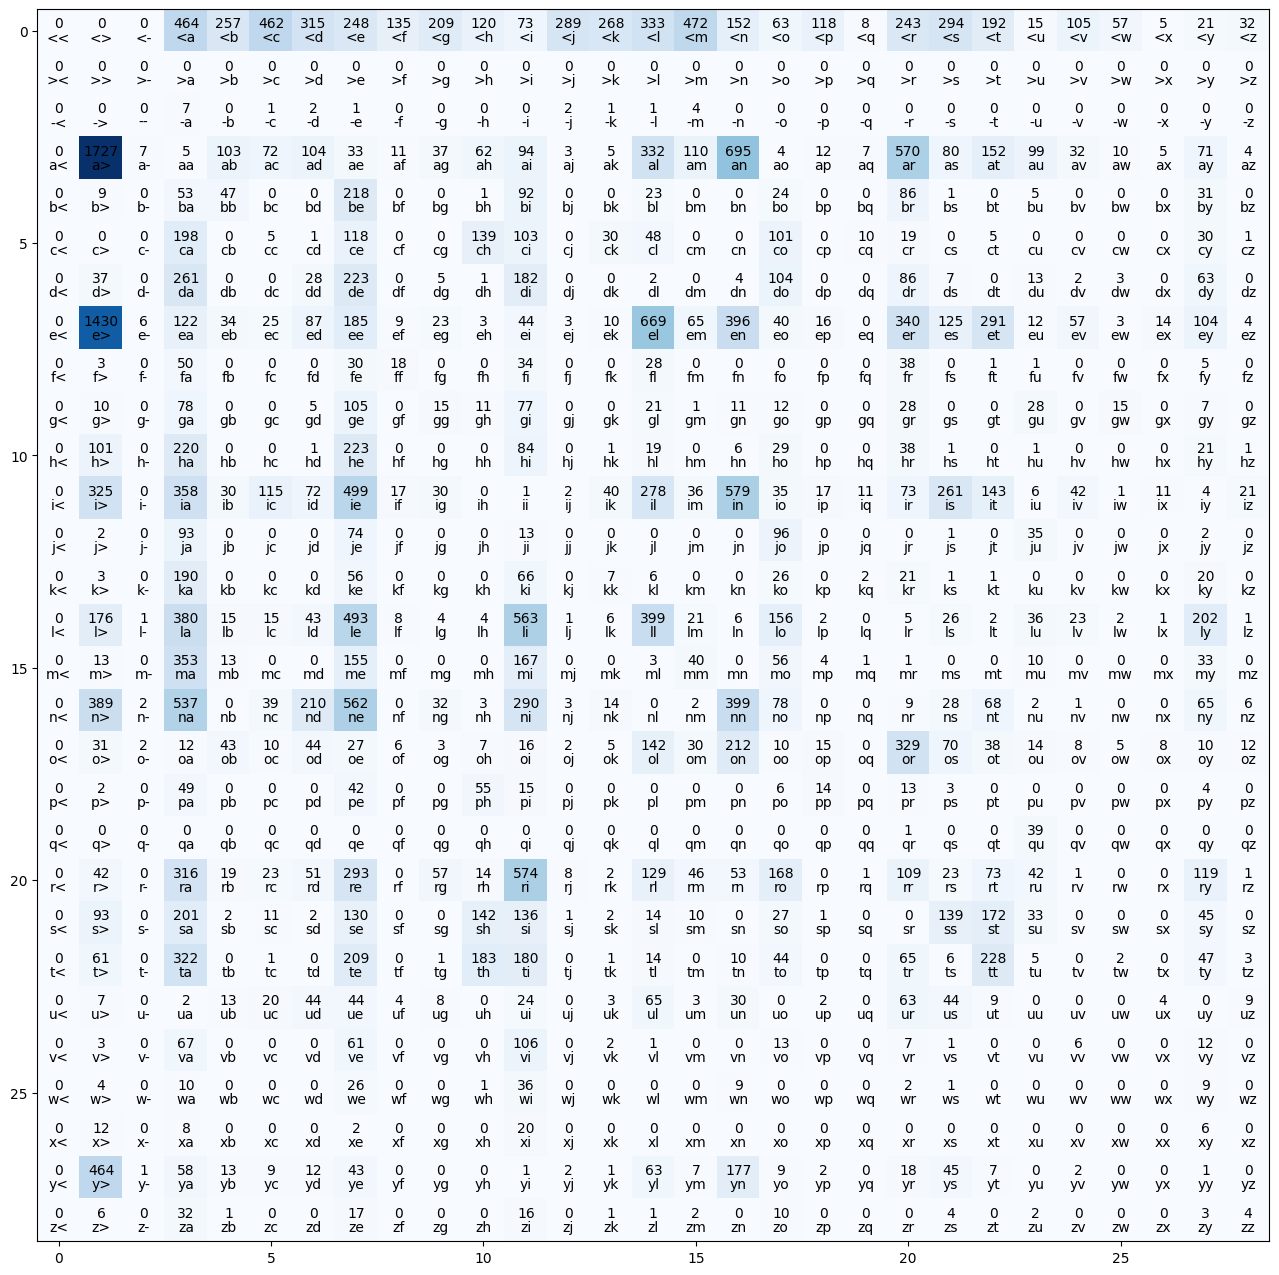

In [14]:
# just use matplotlib here, easier to add on
plt.figure(figsize=(16, 16))
plt.imshow(bigram_counts_tensor, cmap="Blues")

# add text annotations
for i, j in np.ndindex(bigram_counts_tensor.shape):

    # convert to tokens
    token_1, token_2 = decode_single(i), decode_single(j)

    # TODO(bschoen): Why are j and i reversed? Is this because matplotlib indexes from the top down?
    plt.text(j, i, bigram_counts_tensor[i, j].item(), ha="center", va="bottom")
    plt.text(j, i, token_1 + token_2, ha="center", va="top")

plt.show()

In [15]:
# plot heatmap, then look for the most common to sanity check

# nice this is much easier than bokeh

text_annotations = tensor_utils.apply_by_index_each_in_2d_tensor(
    bigram_counts_tensor,
    lambda i, j: f"{decode_single(i)}{decode_single(j)}",
)

# TODO(bschoen): Make this something generic, since heatmaps are common

# note: we need to drop down into heatmap to show text annotations
fig = go.Figure(
    data=go.Heatmap(
        # x=unique_chars,
        # y=unique_chars,
        z=bigram_counts_tensor.numpy(),
        text=text_annotations,
        texttemplate="%{text}",
        textfont={"size": 9},
    )
)

fig.update_layout(
    title="Bigram Counts",
    xaxis_title="Next Char",
    yaxis_title="Char",
    width=1000,
    height=1000,
)

fig.show()

# Look at probabilities for a single source token

In [16]:
# now we have the bigram counts, so let's create a probability distribution
# we can sample from
#
# note: for now we're just looking at the token probs? Just the first character?
#
# probabilities of ['<a', '<b', '<c', ...] etc
#
source_token_index = 0
token_probs = bigram_counts_tensor[source_token_index].float()
token_probs = token_probs / token_probs.sum()

tensor_utils.debug_tensor(token_probs)

Tensor:
  Shape: torch.Size([29])
  Dtype: torch.float32
  Device: cpu
  Sample values:
       +0.000    +0.000    +0.000    +0.094    +0.052   ...


In [17]:
# show some values to get a sense for what's in them and sanity check based
# on bigram `('.', x)`
source_char = decode_single(source_token_index)

print(f"Top next characters for `{source_char}`:")
topk_token_probs = torch.topk(token_probs, k=10)

for token_prob, token_index in zip(topk_token_probs.values, topk_token_probs.indices):
    next_char = decode_single(token_index.item())
    print(f" - {source_char}{next_char}: {token_prob.item():.4f}")

Top next characters for `<`:
 - <m: 0.0954
 - <a: 0.0937
 - <c: 0.0933
 - <l: 0.0673
 - <d: 0.0636
 - <s: 0.0594
 - <j: 0.0584
 - <k: 0.0541
 - <b: 0.0519
 - <e: 0.0501


In [18]:
rand_gen = torch.Generator().manual_seed(42)

# sample from the distribution
num_samples = 100

# note: this is why tokens and token_index are often used interchangeably
sampled_tokens = torch.multinomial(
    token_probs,
    num_samples=num_samples,
    generator=rand_gen,
    replacement=True,
)

tensor_utils.debug_tensor(sampled_tokens, "Sampled Tokens")

# decode it
decoded_sample = decode(sampled_tokens.tolist())
print(f"\nDecoded: {decoded_sample}")

# sanity check that the most common
#
# [('a', 15), ('l', 11), ('m', 11), ('b', 9), ...]
#
# we can see that `a` and `m` are pretty frequent, consistent with what we expect
#
# note: needed a sample size of around 100 to confirm, as 10 had no `m`s
#
collections.Counter(decoded_sample).most_common(10)

Sampled Tokens:
  Shape: torch.Size([100])
  Dtype: torch.int64
  Device: cpu
  Sample values:
       3    3    4    3   13   ...

Decoded: aabakjutabcfrsflamlhameeaatcdbdccellraehtbhdwrgbmlmjbljzcfldamdlfhlsmbkveamakmbdljmcsvcmabtmajtdklav


[('a', 15),
 ('l', 11),
 ('m', 11),
 ('b', 9),
 ('c', 7),
 ('d', 7),
 ('j', 5),
 ('t', 5),
 ('e', 5),
 ('k', 4)]

# Look at probabilities for each source token

In [246]:
# now we'll do all the source tokens at once

"""
The +1 is a technique called "additive smoothing" or "Laplace smoothing".

Why?
 - It's used to avoid zero probabilities for character combinations that
   don't appear in the training data.

Benefits?
 - Prevents the model from assigning zero probability to unseen events.
 - Improves generalization by allowing for character combinations not seen in training.

How?
 - It adds a small constant (in this case, 1) to all counts before normalizing.
 - This ensures that even character pairs that never occurred in the training data
   have a small, non-zero probability.

Impact?
 - For frequent pairs, the +1 has minimal effect.
 - For rare or unseen pairs, it provides a small but non-zero probability.

 Why +1:
 - +1 is commonly used (known as "Laplace smoothing"), but other small values can be used too.
 - The choice of +1 is often a good balance between:
   - smoothing
   - maintaining the relative frequencies observed in the data.

"""
token_probs = (bigram_counts_tensor + 1).float()

# divide each row by it's respective sum
#
# essentially we're normalizing the rows so they sum to 1
#
token_probs = token_probs / token_probs.sum(dim=1, keepdim=True)

tensor_utils.debug_tensor(token_probs)

Tensor:
  Shape: torch.Size([29, 29])
  Dtype: torch.float32
  Device: cpu
  Sample values:
    Row 0:    +0.000    +0.000    +0.000    +0.094    +0.052   ...
    Row 1:      +nan      +nan      +nan      +nan      +nan   ...
    Row 2:    +0.000    +0.000    +0.000    +0.368    +0.000   ...
    Row 3:    +0.000    +0.388    +0.002    +0.001    +0.023   ...
    Row 4:    +0.000    +0.015    +0.000    +0.090    +0.080   ...
    ...


In [20]:
rand_gen = torch.Generator().manual_seed(42)

# sample from the distribution
num_samples = 100

sampled_tokens = torch.multinomial(
    token_probs,
    num_samples=num_samples,
    generator=rand_gen,
    replacement=True,
)

tensor_utils.debug_tensor(sampled_tokens, "Sampled Tokens")

for i in range(sampled_tokens.shape[0]):

    source_char = decode_single(i)

    decoded_next_chars = decode(sampled_tokens[i].tolist())

    # stop at the first end token
    decoded_next_chars = decoded_next_chars.split(SpecialTokens.END.value)[0]

    decoded_next_chars_counter = collections.Counter(decoded_next_chars)

    print(f"\n`{source_char}`: {decoded_next_chars}")
    print(f"     {decoded_next_chars_counter.most_common(5)}")

Sampled Tokens:
  Shape: torch.Size([29, 100])
  Dtype: torch.int64
  Device: cpu
  Sample values:
    Row 0:    3    3    4    3   13   ...
    Row 1:   10   10   23   16   20   ...
    Row 2:   23    6    0    4   27   ...
    Row 3:   20    1    1    7    1   ...
    Row 4:    7    7   17   11    7   ...
    ...

`<`: aabakjvtabcfrsflamlhameeaatcdbdccellraehtbhdwrgbmlmjaljzcfldamdlfhlsmbkveamakmbdljmcsvcmabtmajtdklav
     [('a', 16), ('l', 11), ('m', 11), ('b', 8), ('c', 7)]

`>`: hhunrmkhnpic<<dsx-ynpceiurftd<vwlj-xltrd-phchmiljqapsiosmuqidykexryzlbpztwg-
     [('h', 5), ('p', 5), ('i', 5), ('r', 4), ('d', 4)]

`-`: ud<bysrsedq<adkugrhapvsaammavkpfjmtk
     [('a', 5), ('d', 3), ('s', 3), ('k', 3), ('m', 3)]

`a`: r
     [('r', 1)]

`b`: eeoieaaeeyylre
     [('e', 6), ('a', 2), ('y', 2), ('o', 1), ('i', 1)]

`c`: orqieaihaeehakizyaralaeioohrhtohahooaikhoheirhieikeeeoeehrhetaeo-aetkaiqaaaiaiooeaoeaoeraaehhriiaqok
     [('a', 20), ('e', 18), ('o', 14), ('i', 13), ('h', 13)]

`d`: yiei

# Generate text

In [22]:
# sample in order, like we'd do for generate

rand_gen = torch.Generator().manual_seed(42)


def generate_text(token_probs: Float32[torch.Tensor, "src dst"]) -> str:

    output = "<"

    while output[-1] != ">":

        # get the last char
        source_char = output[-1]

        # get the token index
        source_token_index = encode_single(source_char)

        # get the probabilities for the next tokens given the source
        token_probs_for_source = token_probs[source_token_index]

        # sample a single next token
        sampled_token = torch.multinomial(
            token_probs_for_source,
            num_samples=1,
            generator=rand_gen,
            replacement=True,
        )

        # decode it
        next_char = decode_single(sampled_token.item())

        # add it to the output
        output += next_char

    return output


# note: these aren't terrible

python_utils.print_json([generate_text(token_probs) for _ in range(10)])

print(
    "Showing some random names as a sanity check that we're doing something meaningful"
)

python_utils.print_json(
    [generate_text(torch.rand_like(token_probs)) for _ in range(10)]
)

[
  "<a>",
  "<o>",
  "<ka>",
  "<fineaba>",
  "<lyniky>",
  "<jaroselele>",
  "<mista>",
  "<dorieria>",
  "<minanele>",
  "<caneyndrman>"
]
Showing some random names as a sanity check that we're doing something meaningful
[
  "<>",
  "<kyd-xmsf>",
  "<pqpmsbsmpadonjfz-utz-ibcipg<pxfjacew>",
  "<bjezfknpnjwyz<wuvbwxhhfsudrvjcotnpjtbzxjlxbdnhjfozcuuntjcuentcermuhudlskif>",
  "<w-ronexkwauyoctut-leujekpzxci-lzobmoljqmlwce<jobbmezrarsv<hv>",
  "<bcr--<<rkzvwyzo>",
  "<q<vdfyewoks-eozjyhbtqlonmthjgy<exytcz>",
  "<nciehzioykuae>",
  "<<kagvpjsjrmi-uvfjewyrq-vtxghtvfhbt>",
  "<e-xc>"
]


# Loss Function

In [ ]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [247]:
# want to know how likely the model thinks each bigram is

# because we're multiplying probs together, the liklihood is the product of all
# these, but it gets really small (since multiplying a bunch of numbers smaller than 1)
#
# we then take the log so we don't have to work with as small of numbers
#
# we make it negative so that we get positive values to work with (and minimize,
# which makes it nicely compatible with other loss functions)
#
# logs have the other nice property that:
#
#   log(a*b*c) = log(a) + log(b) + log(c)
#
# so we can avoid the precision loss of multiplying many small numbers together
#
log_likelihood = 0

# note: this looks over the whole training set
bigrams_for_words = list(get_bigrams_from_words(words))

for char_1, char_2 in bigrams_for_words:

    token_1, token_2 = encode_single(char_1), encode_single(char_2)

    # each time we saw something in the training set, MULTIPLY the probability
    #
    # basically each time we saw it:
    # - what are the chances that the model thinks we would see it
    #
    # basically what are the chances the model would predict this exact sequence IN ORDER
    #
    # for example, if the model encoded more context, it could be holding the
    # entire sequence seen so far, i.e. a memorizer model that's just a stack
    #
    # so is cross entropy just doing this with a `target`?
    token_prob = token_probs[token_1, token_2]

    log_token_prob = torch.log(token_prob)

    # log(a*b) = log(a) + log(b)
    log_likelihood += log_token_prob

    print(
        f"{char_1}{char_2}"
        f"\tprob: {token_prob.item():.4f}"
        f"\tlog_prob: {log_token_prob.item():.4f}"
    )

print()

print(f"Negative log liklihood: {-log_likelihood:.6f}")

# we usually want to average so we can compare runs of different sizes
# averaged over the number of bigrams, NOT all tokens
avg_negative_log_likelihood = -log_likelihood / len(bigrams_for_words)

print(f"Average negative log likelihood: {avg_negative_log_likelihood:6f}")

# note: as a benchmark, imagine if everything equally likely / random
#       - would expect everything to be ~1/29 = ~3.4%
#
#       - so can see that our model is better than chance at some of these

<a	prob: 0.0937	log_prob: -2.3673
aa	prob: 0.0011	log_prob: -6.7903
ar	prob: 0.1282	log_prob: -2.0541
re	prob: 0.1354	log_prob: -1.9995
en	prob: 0.0962	log_prob: -2.3415
n>	prob: 0.1420	log_prob: -1.9518
<a	prob: 0.0937	log_prob: -2.3673
aa	prob: 0.0011	log_prob: -6.7903
ar	prob: 0.1282	log_prob: -2.0541
ri	prob: 0.2652	log_prob: -1.3271
ik	prob: 0.0133	log_prob: -4.3198
ka	prob: 0.4762	log_prob: -0.7419
a>	prob: 0.3884	log_prob: -0.9456
<a	prob: 0.0937	log_prob: -2.3673
ab	prob: 0.0232	log_prob: -3.7650
ba	prob: 0.0898	log_prob: -2.4098
ag	prob: 0.0083	log_prob: -4.7888
ga	prob: 0.1840	log_prob: -1.6930
ae	prob: 0.0074	log_prob: -4.9033
el	prob: 0.1625	log_prob: -1.8171
l>	prob: 0.0679	log_prob: -2.6893
<a	prob: 0.0937	log_prob: -2.3673
ab	prob: 0.0232	log_prob: -3.7650
ba	prob: 0.0898	log_prob: -2.4098
ag	prob: 0.0083	log_prob: -4.7888
ga	prob: 0.1840	log_prob: -1.6930
ai	prob: 0.0211	log_prob: -3.8565
il	prob: 0.0925	log_prob: -2.3811
l>	prob: 0.0679	log_prob: -2.6893
<a	prob: 0.093

In [52]:
# we can pull that out into a function, and get the loss for an arbitrary sequence
def get_negative_log_likelihood(
    token_probs: Float32[torch.Tensor, "src dst"],
    word: str,
) -> float:

    log_likelihood = 0

    bigrams_for_word = list(get_bigrams_from_word(word))

    for char_1, char_2 in bigrams_for_word:

        token_1, token_2 = encode_single(char_1), encode_single(char_2)

        token_prob = token_probs[token_1, token_2]

        log_token_prob = torch.log(token_prob)

        log_likelihood += log_token_prob

    return -log_likelihood / len(bigrams_for_word)


get_negative_log_likelihood(token_probs, "a")

tensor(1.6612)

# Memorizer Model

In [34]:
# we'll construct a toy model that memorizes the entire input and plays it back
#
# -> this should give us perfect loss
class MemorizerModel: ...

tensor(4.6005)

# Neural Network Approach - Single Linear Layer (No Bias or Nonlinearity)

In [53]:
# want to essentially find the best possible bigram model using a neural network

In [60]:
# create the training set
all_bigrams = list(get_bigrams_from_words(words))

X = torch.tensor([encode_single(bigram[0]) for bigram in all_bigrams])
Y = torch.tensor([encode_single(bigram[1]) for bigram in all_bigrams])

tensor_utils.debug_tensor(X)
tensor_utils.debug_tensor(Y)

Tensor:
  Shape: torch.Size([35148])
  Dtype: torch.int64
  Device: cpu
  Sample values:
       0    3    3   20    7   ...
Tensor:
  Shape: torch.Size([35148])
  Dtype: torch.int64
  Device: cpu
  Sample values:
       3    3   20    7   16   ...


In [73]:
# Why one hot encoding?
"""
One-hot encodes the input tokens allowing network to learn separate weights for each.

This also allows the dimensions to now be floats! 

One-hot encoding is used for:
1. Representing categorical data without implying ordinal relationships
2. Creating input vectors where each dimension corresponds to a character
3. Allowing interpretation of output as probabilities
4. Avoiding arbitrary numerical relationships between characters
5. Compatibility with common neural network loss functions

This encoding enables the network to learn flexible mappings between
characters and capture complex patterns beyond simple counting statistics.
"""

X_enc = F.one_hot(X, num_classes=len(unique_chars)).float()

tensor_utils.debug_tensor(X_enc)

Tensor:
  Shape: torch.Size([35148, 29])
  Dtype: torch.float32
  Device: cpu
  Sample values:
    Row 0:    +1.000    +0.000    +0.000    +0.000    +0.000   ...
    Row 1:    +0.000    +0.000    +0.000    +1.000    +0.000   ...
    Row 2:    +0.000    +0.000    +0.000    +1.000    +0.000   ...
    Row 3:    +0.000    +0.000    +0.000    +0.000    +0.000   ...
    Row 4:    +0.000    +0.000    +0.000    +0.000    +0.000   ...
    ...


In [255]:
def show_activation_heatmap(
    activation: torch.Tensor,
    title: str = "Title",
) -> None:

    # if there's any negative values, center the color at 0
    color_continuous_scale = "Reds"
    color_continuous_midpoint = None

    if torch.min(activation).item() < 0:

        color_continuous_scale = "RdBu_r"
        color_continuous_midpoint = 0

    fig = px.imshow(
        activation.numpy(),
        color_continuous_scale=color_continuous_scale,
        color_continuous_midpoint=color_continuous_midpoint,
        title=title,
        labels={
            "x": "Neuron",
            "y": "Sample",
            "color": "Activation",
        },
    )

    # Adjust layout to reduce whitespace and align title with x-axis
    height_scale_factor = 40
    fig.update_layout(
        margin=dict(l=50, r=50, t=50, b=50),  # Reduce margins
        # width=800,  # Set a fixed width
        # Set a fixed height scaled to y dimension
        height=min(height_scale_factor * activation.shape[0], 600),
        xaxis_title_standoff=10,  # Reduce space between x-axis and title
        yaxis_title_standoff=10,  # Reduce space between y-axis and title
    )

    # Adjust axes to reduce whitespace
    fig.update_xaxes(automargin=True)
    fig.update_yaxes(automargin=True)

    fig.show()

In [74]:
# let's go ahead and take a few examples as we walk through
X_enc = X_enc[:5]

tensor_utils.debug_tensor(X_enc)

print(list(get_bigrams_from_word(words[0])))

px.imshow(X_enc.numpy(), x=unique_chars)

Tensor:
  Shape: torch.Size([5, 29])
  Dtype: torch.float32
  Device: cpu
  Sample values:
    Row 0:    +1.000    +0.000    +0.000    +0.000    +0.000   ...
    Row 1:    +0.000    +0.000    +0.000    +1.000    +0.000   ...
    Row 2:    +0.000    +0.000    +0.000    +1.000    +0.000   ...
    Row 3:    +0.000    +0.000    +0.000    +0.000    +0.000   ...
    Row 4:    +0.000    +0.000    +0.000    +0.000    +0.000   ...
[('<', 'a'), ('a', 'a'), ('a', 'r'), ('r', 'e'), ('e', 'n'), ('n', '>')]


In [79]:
# now let's start defining a neuron

num_neurons = 1

W = torch.randn((len(unique_chars), num_neurons))

tensor_utils.debug_tensor(W)
tensor_utils.debug_tensor(X_enc)

X_enc @ W

Tensor:
  Shape: torch.Size([29, 1])
  Dtype: torch.float32
  Device: cpu
  Sample values:
    Row 0:    -2.176
    Row 1:    +0.919
    Row 2:    -0.252
    Row 3:    +0.085
    Row 4:    +0.291
    ...
Tensor:
  Shape: torch.Size([5, 29])
  Dtype: torch.float32
  Device: cpu
  Sample values:
    Row 0:    +1.000    +0.000    +0.000    +0.000    +0.000   ...
    Row 1:    +0.000    +0.000    +0.000    +1.000    +0.000   ...
    Row 2:    +0.000    +0.000    +0.000    +1.000    +0.000   ...
    Row 3:    +0.000    +0.000    +0.000    +0.000    +0.000   ...
    Row 4:    +0.000    +0.000    +0.000    +0.000    +0.000   ...


tensor([[-2.1765],
        [ 0.0848],
        [ 0.0848],
        [-0.6879],
        [-1.1156]])

In [203]:
num_neurons = 10

W = torch.randn((len(unique_chars), num_neurons))

tensor_utils.debug_tensor(W)
tensor_utils.debug_tensor(X_enc)

activation = X_enc @ W

tensor_utils.debug_tensor(activation, "Activation")

show_activation_heatmap(activation)

Tensor:
  Shape: torch.Size([29, 10])
  Dtype: torch.float32
  Device: cpu
  Sample values:
    Row 0:    -0.341    -0.975    +0.055    +0.049    -0.000   ...
    Row 1:    +0.811    +0.000    -0.088    -1.189    -0.744   ...
    Row 2:    +1.046    -0.927    -1.361    +0.817    +0.023   ...
    Row 3:    -0.612    +0.059    -0.473    +0.226    +2.152   ...
    Row 4:    +0.332    +0.875    +0.922    +0.279    +0.962   ...
    ...
Tensor:
  Shape: torch.Size([5, 29])
  Dtype: torch.float32
  Device: cpu
  Sample values:
    Row 0:    +1.000    +0.000    +0.000    +0.000    +0.000   ...
    Row 1:    +0.000    +0.000    +0.000    +1.000    +0.000   ...
    Row 2:    +0.000    +0.000    +0.000    +1.000    +0.000   ...
    Row 3:    +0.000    +0.000    +0.000    +0.000    +0.000   ...
    Row 4:    +0.000    +0.000    +0.000    +0.000    +0.000   ...
Activation:
  Shape: torch.Size([5, 10])
  Dtype: torch.float32
  Device: cpu
  Sample values:
    Row 0:    -0.341    -0.975    +0.055    

In [97]:
# this is the same as
sample_index = 3
neuron_index = 7

print(f"{activation[sample_index, neuron_index]=}")

print(f"{X_enc[sample_index] @ W[:, neuron_index]=}")

activation[sample_index, neuron_index]=tensor(0.9745)
X_enc[sample_index] @ W[:, neuron_index]=tensor(0.9745)


In [204]:
# okay, but how do we interpret these?

# first, we'll make our embedding dimension match the vocab size, so we don't have
# to deal with unembedding yet
W = torch.randn((len(unique_chars), len(unique_chars)))

# TODO(bschoen): This seems fishy
# - essentially the neural network gives us *something*
#   - we interpret that as logits because it's convenient for us
#   - we then get the neural network to learn these
#   - so it's trying to get the weights that get closest to producing the correct logits
#   - this makes sense given that our loss function is looking at the logits
#
# next, we want the neural network to predict the probabilities of the next character
# - we can't just use counts, because we don't really want integers
# - so we'll interpret them as log counts (LOGITS)
# - this means we exponentiate them to get the actual counts
#  - acts like a line between [-1, 1]
#  - maps the entire real line
#  - maps everything positive
#
# - that means we'd have to normalize to get the probabilities

tensor_utils.debug_tensor(W)
tensor_utils.debug_tensor(X_enc)

logits = X_enc @ W
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)

# this is equivalent to
probs = F.softmax(logits, dim=1)

tensor_utils.debug_tensor(logits, "Activation")

show_activation_heatmap(logits, "Logits")
show_activation_heatmap(counts, "Counts")
show_activation_heatmap(probs, "Probs")

Tensor:
  Shape: torch.Size([29, 29])
  Dtype: torch.float32
  Device: cpu
  Sample values:
    Row 0:    +0.345    -0.049    +1.340    -0.437    -0.021   ...
    Row 1:    +0.173    +0.628    -0.440    -2.386    -1.124   ...
    Row 2:    +0.714    +0.530    +0.855    -0.198    -1.813   ...
    Row 3:    +0.448    -0.504    +0.012    -0.557    +0.021   ...
    Row 4:    +1.072    -0.768    -0.041    -0.108    +0.213   ...
    ...
Tensor:
  Shape: torch.Size([5, 29])
  Dtype: torch.float32
  Device: cpu
  Sample values:
    Row 0:    +1.000    +0.000    +0.000    +0.000    +0.000   ...
    Row 1:    +0.000    +0.000    +0.000    +1.000    +0.000   ...
    Row 2:    +0.000    +0.000    +0.000    +1.000    +0.000   ...
    Row 3:    +0.000    +0.000    +0.000    +0.000    +0.000   ...
    Row 4:    +0.000    +0.000    +0.000    +0.000    +0.000   ...
Activation:
  Shape: torch.Size([5, 29])
  Dtype: torch.float32
  Device: cpu
  Sample values:
    Row 0:    +0.345    -0.049    +1.340    

In [148]:
import termcolor


def to_color(text: str, color: str) -> str:
    text = text if isinstance(text, str) else str(text)
    return termcolor.colored(text, color)


def to_red(text: str) -> str:
    return to_color(text, "red")


def to_cyan(text: str) -> str:
    return to_color(text, "cyan")


def cprint(prefix: str, text: str, color: str = "cyan") -> None:
    print(f"{prefix}{to_color(text, color)}")

In [156]:
nlls = torch.zeros(5)

for i in range(5):

    # i-th bigram:
    x = X[i].item()  # input character index
    y = Y[i].item()  # label character index

    print("--------")
    cprint(
        "bigram example ",
        f"{i+1}: {decode_single(x)}{decode_single(y)} (indexes {x},{y})",
    )

    cprint("input to the neural net: ", f"{decode_single(x)}")

    cprint("output probabilities from the neural net:\n", f"{probs[i]}")

    cprint("label (actual next character): ", f"{decode_single(y)}")

    p = probs[i, y]
    cprint(
        "probability assigned by the net to the the correct character: ",
        f"{p.item():.4f}",
    )

    logp = torch.log(p)
    cprint("log likelihood: ", f"{logp.item():.4f}")

    nll = -logp
    cprint("negative log likelihood: ", f"{nll.item():.4f}")

    nlls[i] = nll

print("=========")
print(f"average negative log likelihood, i.e. loss = {nlls.mean().item():.4f}")

--------
bigram example 1: <a (indexes 0,3)
input to the neural net: <
output probabilities from the neural net:
tensor([0.0154, 0.0211, 0.0266, 0.0311, 0.0160, 0.0290, 0.0498, 0.0440, 0.1200,
        0.0848, 0.0791, 0.0133, 0.0321, 0.0171, 0.0060, 0.0100, 0.0795, 0.0442,
        0.0082, 0.0096, 0.0135, 0.0080, 0.0183, 0.0094, 0.0085, 0.0342, 0.0419,
        0.0285, 0.1009])
label (actual next character): a
probability assigned by the net to the the correct character: 0.0311
log likelihood: -3.4692
negative log likelihood: 3.4692
--------
bigram example 2: aa (indexes 3,3)
input to the neural net: a
output probabilities from the neural net:
tensor([0.0372, 0.0137, 0.0346, 0.0177, 0.0322, 0.0236, 0.0580, 0.0481, 0.0080,
        0.0182, 0.0079, 0.0226, 0.0411, 0.0727, 0.0409, 0.0790, 0.0189, 0.0133,
        0.1020, 0.0169, 0.0628, 0.0228, 0.0742, 0.0067, 0.0039, 0.0149, 0.0785,
        0.0288, 0.0010])
label (actual next character): a
probability assigned by the net to the the correct ch

## Optimizing the Neural Network

In [210]:
# create new weights
W = torch.randn((len(unique_chars), len(unique_chars)), requires_grad=True)

# forward pass

xs = X[:5]
ys = Y[:5]
# input to the network: one-hot encoding
x_enc = F.one_hot(xs, num_classes=len(unique_chars)).float()

# predict log-counts
logits = x_enc @ W

# counts, equivalent to N
counts = logits.exp()

# probabilities for next character
probs = counts / counts.sum(1, keepdims=True)

# average negative log likelihood
loss = -probs[torch.arange(len(xs)), ys].log().mean()

cprint("loss: ", f"{loss.item():.6f}")

loss: 3.553922


In [211]:
# backward pass
W.grad = None  # set to zero the gradient
loss.backward()

cprint("W.grad: ", f"{W.grad}")

W.grad: tensor([[ 0.0046,  0.0020,  0.0027, -0.1791,  0.0043,  0.0006,  0.0141,  0.0014,
          0.0016,  0.0122,  0.0083,  0.0020,  0.0084,  0.0433,  0.0077,  0.0091,
          0.0010,  0.0010,  0.0023,  0.0006,  0.0084,  0.0014,  0.0053,  0.0031,
          0.0014,  0.0133,  0.0061,  0.0080,  0.0050],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0064,  0.0138,  0.0044, -0.1944,  0.0189,  0.0125,  0.0836,  0.0014,
          0.0051,

In [218]:
tensor_utils.debug_tensor(W.grad)

show_activation_heatmap(x_enc.detach(), "activation")

show_activation_heatmap(probs.detach(), "probs")

show_activation_heatmap(W.grad, "W.grad")

show_activation_heatmap(W.detach(), "W")

Tensor:
  Shape: torch.Size([29, 29])
  Dtype: torch.float32
  Device: cpu
  Sample values:
    Row 0:    +0.005    +0.002    +0.003    -0.179    +0.004   ...
    Row 1:    +0.000    +0.000    +0.000    +0.000    +0.000   ...
    Row 2:    +0.000    +0.000    +0.000    +0.000    +0.000   ...
    Row 3:    +0.006    +0.014    +0.004    -0.194    +0.019   ...
    Row 4:    +0.000    +0.000    +0.000    +0.000    +0.000   ...
    ...


In [219]:
# actually do the weight update
W.data += -0.1 * W.grad

# we can see `neuron 3` in this example got stronger by exactly `-0.1 * W.grad`
show_activation_heatmap(W.detach(), "W")

## Putting Everything Together

In [242]:
# create the training set
all_bigrams = list(get_bigrams_from_words(words))

X = torch.tensor([encode_single(bigram[0]) for bigram in all_bigrams])
Y = torch.tensor([encode_single(bigram[1]) for bigram in all_bigrams])

# filter down to subset
xs = X  # X[:5]
ys = Y  # Y[:5]

# create the weights
W = torch.randn((len(unique_chars), len(unique_chars)), requires_grad=True)

# gradient descent
num_epochs = 10000
learning_rate = 1e1

print(
    f"Num Epochs: {num_epochs}, "
    f"Learning Rate: {learning_rate}, "
    f"Num Samples: {len(xs)}"
)

for epoch in range(num_epochs):

    # -- forward pass --

    # one hot encode

    # note: only have to one hot encode inputs, this is essentially a poor man's embedding
    #       layer (this is why it happens in the loop)
    x_enc = F.one_hot(xs, num_classes=len(unique_chars)).float()

    # predict log-counts
    logits = x_enc @ W

    # counts, equivalent to N
    counts = logits.exp()

    # probabilities for next character
    probs = counts / counts.sum(1, keepdims=True)

    # poor man's unembedding layer from the onehot encoding
    probs_dec = probs[torch.arange(len(xs)), ys]

    # average negative log likelihood
    loss = -probs_dec.log().mean()

    # -- backward pass --
    W.grad = None  # set to zero the gradient
    loss.backward()

    # update
    W.data += -learning_rate * W.grad

    print(f"Epoch {epoch+1} loss: {loss.item():.6f}")

# What do we expect to get for the loss?
# - we expect it to essentially learn the bigram model
#   - which had:
#
#       Average negative log likelihood: 2.283297
#
# - here after:
#
#       Num Epochs: 100, Learning Rate: 100.0, Num Samples: 35148
#
#       Epoch 100 loss: 2.384281
#
# - which is pretty close!
#
# - in fact, after training as hard as possible:
#
#      Num Epochs: 10000, Learning Rate: 10.0, Num Samples: 35148
#
#       Epoch 10000 loss: 2.274852
#
# - we max out around the value given by the bigram model
# - this makes sense, as the bigram model is literally just:
#
#       bigram_counts_tensor ~ W
#
# - so the model is learning specifically to adjust W to rediscover the bigram counts,
#   which it uses as it's model weights
#
# - it seemed a bit suspiscious that the model could do better than bigram
#
# - if we remove the laplace smoothing, we get:
#
#       Average negative log likelihood: 2.273306
#
# - which actually slightly beats the model!

Num Epochs: 10000, Learning Rate: 10.0, Num Samples: 35148
Epoch 1 loss: 3.742108
Epoch 2 loss: 3.634537
Epoch 3 loss: 3.536830
Epoch 4 loss: 3.448666
Epoch 5 loss: 3.369926
Epoch 6 loss: 3.300163
Epoch 7 loss: 3.238500
Epoch 8 loss: 3.183878
Epoch 9 loss: 3.135306
Epoch 10 loss: 3.091927
Epoch 11 loss: 3.052969
Epoch 12 loss: 3.017730
Epoch 13 loss: 2.985593
Epoch 14 loss: 2.956054
Epoch 15 loss: 2.928724
Epoch 16 loss: 2.903311
Epoch 17 loss: 2.879599
Epoch 18 loss: 2.857415
Epoch 19 loss: 2.836623
Epoch 20 loss: 2.817106
Epoch 21 loss: 2.798764
Epoch 22 loss: 2.781508
Epoch 23 loss: 2.765259
Epoch 24 loss: 2.749943
Epoch 25 loss: 2.735497
Epoch 26 loss: 2.721861
Epoch 27 loss: 2.708979
Epoch 28 loss: 2.696800
Epoch 29 loss: 2.685277
Epoch 30 loss: 2.674364
Epoch 31 loss: 2.664019
Epoch 32 loss: 2.654203
Epoch 33 loss: 2.644879
Epoch 34 loss: 2.636011
Epoch 35 loss: 2.627567
Epoch 36 loss: 2.619518
Epoch 37 loss: 2.611835
Epoch 38 loss: 2.604492
Epoch 39 loss: 2.597467
Epoch 40 loss:

In [ ]:
# TODO(bschoen): Actually how can the weights do slightly better than the bigram model?

Test small number of examples:

```python
Num Epochs: 10, Learning Rate: 0.1, Num Samples: 5
Epoch 1 loss: 4.188750
Epoch 2 loss: 4.166784
Epoch 3 loss: 4.144858
Epoch 4 loss: 4.122970
Epoch 5 loss: 4.101122
Epoch 6 loss: 4.079313
Epoch 7 loss: 4.057544
Epoch 8 loss: 4.035815
Epoch 9 loss: 4.014125
Epoch 10 loss: 3.992476
```

Increase size to full training set:

```python
Num Epochs: 10, Learning Rate: 0.1, Num Samples: 35148
Epoch 1 loss: 3.724103
Epoch 2 loss: 3.723007
Epoch 3 loss: 3.721911
Epoch 4 loss: 3.720816
Epoch 5 loss: 3.719723
Epoch 6 loss: 3.718630
Epoch 7 loss: 3.717538
Epoch 8 loss: 3.716446
Epoch 9 loss: 3.715356
Epoch 10 loss: 3.714267
```

We can see that loss is decreasing really slowly, so we can probably increase
the learning rate:

```python
Num Epochs: 10, Learning Rate: 100.0, Num Samples: 35148
Epoch 1 loss: 3.749386
Epoch 2 loss: 3.049868
Epoch 3 loss: 2.937815
Epoch 4 loss: 2.751288
Epoch 5 loss: 2.781796
Epoch 6 loss: 2.600911
Epoch 7 loss: 2.667333
Epoch 8 loss: 2.567842
Epoch 9 loss: 2.657365
Epoch 10 loss: 2.499151
```

In [256]:
show_activation_heatmap(W.detach(), "W")

In [258]:
token_probs = (bigram_counts_tensor + 1).float()

token_probs = token_probs / token_probs.sum(dim=1, keepdim=True)

show_activation_heatmap(token_probs, "bigram_counts_token_probs")